In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

SEED = 123

In [2]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test_X.csv'

train = pd.read_csv(TRAIN_PATH)
print('Train shape:', train.shape)
test = pd.read_csv(TEST_PATH)
print('Test shape:', test.shape)

Train shape: (138039, 26)
Test shape: (59159, 25)


In [3]:
train_prepared = train.copy()
test_prepared = test.copy()
train.info()
train.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138039 entries, 0 to 138038
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    138039 non-null  int64  
 1   is_fake               138039 non-null  int64  
 2   brand                 79313 non-null   object 
 3   description           121914 non-null  object 
 4   title_name            138039 non-null  object 
 5   category              138039 non-null  object 
 6   rating_1_count        35377 non-null   float64
 7   rating_2_count        35377 non-null   float64
 8   rating_3_count        35377 non-null   float64
 9   rating_4_count        35377 non-null   float64
 10  rating_5_count        35377 non-null   float64
 11  comments_count        35377 non-null   float64
 12  photos_count          35377 non-null   float64
 13  videos_count          35377 non-null   float64
 14  price                 138039 non-null  float64
 15  

,id,is_fake,brand,description,title_name,category,rating_1_count,rating_2_count,rating_3_count,rating_4_count,...,item_count_sales7,item_count_sales30,item_count_sales90,item_count_returns7,item_count_returns30,item_count_returns90,item_variety_count,item_available_count,seller_time_alive,seller_id
0,0,0,ACTRUM,"Мешки пылесборники для пылесоса PHILIPS, 10 шт...","Мешки для пылесоса PHILIPS TRIATLON, синтетиче...",Пылесборник,6.0,4.0,4.0,3.0,...,2,19,61,0,0,1,1.0,1.0,1860.0,1218
1,1,0,Red Line,Защитная силиконовая крышка обьектива GoPro He...,Защитная крышка Redline на экшн-камеру GoPro (...,Крышка для объектива,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1.0,1.0,1757.0,1374
2,2,0,Talwar Brothers,Плоский медиатор из кости толщиной 0.6 мм<br/>...,Медиатор для гитары Acura GP-PB6,Аксессуар для музыкального инструмента,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1.0,1.0,1722.0,1448


In [4]:
svd_components = 90
tfidf = TfidfVectorizer(
    ngram_range=(1, 2), min_df=5, max_df=0.9, max_features=50000, sublinear_tf=True
)
svd = TruncatedSVD(n_components=svd_components, random_state=SEED)

def build_mappings_for_train(df):
    mappings = {}

    df['brand_filled'] = df['brand'].fillna('unknown').astype(str)
    df['category_filled'] = df['category'].fillna('unknown').astype(str)

    brand_freq = df['brand_filled'].value_counts(normalize=True).to_dict()
    category_freq = df['category_filled'].value_counts(normalize=True).to_dict()
    mappings['brand_freq'] = brand_freq
    mappings['category_freq'] = category_freq
    
    brand_labels = {v: i for i, v in enumerate(df['brand_filled'].value_counts().index)}
    category_labels = {v: i for i, v in enumerate(df['category_filled'].value_counts().index)}
    mappings['brand_labels'] = brand_labels
    mappings['category_labels'] = category_labels
    mappings['median_item_variety_count'] = df['item_variety_count'].median()
    mappings['median_item_available_count'] = df['item_available_count'].median()
    rcols = ['rating_1_count','rating_2_count','rating_3_count','rating_4_count','rating_5_count']
    for c in rcols:
        if c not in df.columns:
            df[c] = 0.0
    ratings_sum = (1*df['rating_1_count'].fillna(0) +
                   2*df['rating_2_count'].fillna(0) +
                   3*df['rating_3_count'].fillna(0) +
                   4*df['rating_4_count'].fillna(0) +
                   5*df['rating_5_count'].fillna(0))
    ratings_count = (df['rating_1_count'].fillna(0) + df['rating_2_count'].fillna(0) + 
                     df['rating_3_count'].fillna(0) + df['rating_4_count'].fillna(0) + 
                     df['rating_5_count'].fillna(0))
    weighted = ratings_sum / ratings_count.replace(0, np.nan)
    mappings['median_weighted_rating'] = float(np.nanmedian(weighted.dropna())) if not weighted.dropna().empty else 0.0

    return mappings

def apply_preprocessing(df, mappings=None, is_train=False):
    df = df.copy()

    pattern = r'(replica|copy|реплик|копия|неоригинал|не оригинал|поддел|фейк|fake|неотличим)'
    combined_text = df['title_name'].fillna('') + ' ' + df['description'].fillna('')
    df['has_replica_words'] = combined_text.str.contains(pattern, case=False, regex=True, na=False).astype(int)

    title_text = df["title_name"].fillna("")
    df["title_len"] = title_text.str.len()
    df["title_words"] = title_text.str.split().str.len()
    df["title_upper_ratio"] = (
        title_text.str.count(r"[A-ZА-Я]") / (df["title_len"] + 1))
    df["title_digit_ratio"] = (
        title_text.str.count(r"\d") / (df["title_len"] + 1))
    df["title_unique_ratio"] = (df["title_name"].fillna("").str.split()
        .map(lambda x: len(set(x)) / max(len(x), 1)))

    desc_text = df["description"].fillna("")
    df["desc_len"] = desc_text.str.len()
    df["desc_words"] = desc_text.str.split().str.len()
    df["desc_upper_ratio"] = (
        desc_text.str.count(r"[A-ZА-Я]") / (df["desc_len"] + 1))
    df["desc_digit_ratio"] = (
        desc_text.str.count(r"\d") / (df["desc_len"] + 1))
    df["desc_unique_ratio"] = (df["description"].fillna("").str.split()
        .map(lambda x: len(set(x)) / max(len(x), 1)))

    df['ratings_numerator'] = (1*df['rating_1_count'] + 2*df['rating_2_count'] +
                               3*df['rating_3_count'] + 4*df['rating_4_count'] +
                               5*df['rating_5_count'])
    df['ratings_count'] = (df['rating_1_count'] + df['rating_2_count'] + df['rating_3_count'] +
                           df['rating_4_count'] + df['rating_5_count'])
    df['weighted_rating'] = df['ratings_numerator'] / df['ratings_count'].replace(0, np.nan)
    df['bad_reviews_ratio'] = df['rating_1_count'] + df['rating_2_count'] / (df['ratings_count'] + 1)
    df["brand_in_title"] = df.apply(lambda x: str(x["brand"]).lower() in str(x["title_name"]).lower(), axis=1)
    df["brand_in_desc"] = df.apply(lambda x: str(x["brand"]).lower() in str(x["description"]).lower(), axis=1)
    df["text_hides_brand"] = ((~df["brand_in_title"]) & (~df["brand_in_desc"])).astype(int)
    
    if mappings:
        df['brand_freq'] = df['brand'].map(mappings['brand_freq']).fillna(0.0)
        df['category_freq'] = df['category'].fillna('unknown').map(mappings['category_freq']).fillna(0.0)
        df['brand_label'] = df['brand'].map(mappings['brand_labels']).fillna(-1).astype(int)
        df['category_label'] = df['category'].fillna('unknown').map(mappings['category_labels']).fillna(-1).astype(int)
    else:
        df['brand_freq'] = df['brand'].map(df['brand'].value_counts(normalize=True)).fillna(0.0)
        df['category_freq'] = df['category'].map(df['category'].value_counts(normalize=True)).fillna(0.0)
        df['brand_label'] = pd.factorize(df['brand'])[0]
        df['category_label'] = pd.factorize(df['category'])[0]
    
    for period in [7, 30, 90]:
        df[f"return_ratio_{period}"] = df[f"item_count_returns{period}"] / (df[f"item_count_sales{period}"] + 1)
    df["sales_drop_after_time"] = df["item_count_sales7"] / (df["item_count_sales30"] + 1)
    df["price_log1p"] = np.log1p(df["price"])
    df["seller_item_ratio"] = df["item_available_count"] / (df["item_variety_count"] + 1)
    df["categorial_price"] = (df["price"] - df["category"].map(train.groupby("category")["price"].median())) / df["category"].map(train.groupby("category")["price"].std())
    df["brand_in_title"] = df.apply(lambda x: str(x["brand"]).lower() in str(x["title_name"]).lower(), axis=1)
    df["brand_in_desc"] = df.apply(lambda x: str(x["brand"]).lower() in str(x["description"]).lower(), axis=1)
    df["text_hides_brand"] = ((~df["brand_in_title"]) & (~df["brand_in_desc"])).astype(int)
    df['activity_count'] = df[['comments_count', 'photos_count', 'videos_count']].sum(axis=1)

    title = df["title_name"].fillna("")
    
    if is_train:
        train_tfidf = tfidf.fit_transform(title)
        train_svd = svd.fit_transform(train_tfidf)
        for i in range(svd_components):
            df[f"tfidf_svd_{i}"] = train_svd[:, i]
    else:
        test_tfidf = tfidf.transform(title)
        test_svd = svd.transform(test_tfidf)
        for i in range(svd_components):
            df[f"tfidf_svd_{i}"] = test_svd[:, i]
    
    TEXT_COLS = ["title_name", "description"]

    df = df.drop(columns=TEXT_COLS)

    for col in ["brand", "category"]:
        df[col] = df[col].astype(str).fillna("UNKNOWN")

    BAD_SCORE_COLS = ["brand_filled", "category_filled", "brand_label", "category_label",
                     "brand_freq", "category_freq", "item_available_count",
                      "ratings_numerator", "activity_count"]
    
    df = df.drop(columns=BAD_SCORE_COLS, errors='ignore')
    
    return df


In [5]:
mappings = build_mappings_for_train(train_prepared)
train_prepared = apply_preprocessing(train_prepared, mappings=mappings, is_train=True)
print('Prepared train shape:', train_prepared.shape)
display(train_prepared.head(3))
display(train_prepared.info())

if test is not None:
    test_prepared = apply_preprocessing(test_prepared, mappings=mappings, is_train=False)
    print('Prepared test shape:', test_prepared.shape)
    display(test_prepared.head(3))
else:
    test_prepared = None

Prepared train shape: (138039, 137)


,id,is_fake,brand,category,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,comments_count,...,tfidf_svd_80,tfidf_svd_81,tfidf_svd_82,tfidf_svd_83,tfidf_svd_84,tfidf_svd_85,tfidf_svd_86,tfidf_svd_87,tfidf_svd_88,tfidf_svd_89
0,0,0,ACTRUM,Пылесборник,6.0,4.0,4.0,3.0,32.0,3.0,...,0.009529,-0.027742,-0.010797,0.036026,0.011935,-0.021945,-0.031447,0.014121,-0.023559,-0.014542
1,1,0,Red Line,Крышка для объектива,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009608,0.008272,-0.036394,-0.013097,0.013253,0.015421,0.002491,-0.002190,-0.019520,0.005916
2,2,0,Talwar Brothers,Аксессуар для музыкального инструмента,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.025078,0.005510,-0.013401,-0.007454,0.006052,-0.007085,0.007034,0.032768,0.016844,-0.011876


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138039 entries, 0 to 138038
Columns: 137 entries, id to tfidf_svd_89
dtypes: bool(2), float64(117), int64(16), object(2)
memory usage: 142.4+ MB


None

Prepared test shape: (59159, 136)


,id,brand,category,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,comments_count,photos_count,...,tfidf_svd_80,tfidf_svd_81,tfidf_svd_82,tfidf_svd_83,tfidf_svd_84,tfidf_svd_85,tfidf_svd_86,tfidf_svd_87,tfidf_svd_88,tfidf_svd_89
0,138039,OEM,"Запчасти для стиральной, сушильной машины",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.015071,0.019399,-0.025758,0.012239,0.024258,-0.029824,0.010650,0.022865,0.016372,-0.020712
1,138040,TopON,Клавиатура для ноутбука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.025735,0.005092,0.011347,0.028098,-0.013140,-0.014920,-0.014924,0.040611,0.038141,0.004052
2,138041,RocknParts,Дисплеи для телефонов,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.004177,0.005223,0.012009,0.016705,-0.006527,0.007122,-0.037633,0.019951,0.007108,-0.007426


In [6]:
train_out = './train_prepared.csv'
train_prepared.to_csv(train_out, index=False)
print('Saved prepared train to', train_out)
if test_prepared is not None:
    test_out = './test_prepared.csv'
    test_prepared.to_csv(test_out, index=False)
    print('Saved prepared test to', test_out)
train_prepared.info()

Saved prepared train to ./train_prepared.csv
Saved prepared test to ./test_prepared.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138039 entries, 0 to 138038
Columns: 137 entries, id to tfidf_svd_89
dtypes: bool(2), float64(117), int64(16), object(2)
memory usage: 142.4+ MB


In [7]:
N_FOLDS = 5

y = train_prepared["is_fake"]
X = train_prepared.copy().drop(columns=["is_fake"])
X_test = test_prepared.copy()

X.info()

cat_features = ["brand", "category", "seller_id"]

folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"\n----------- Fold {fold + 1} -----------")

    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=4000,
        learning_rate=0.035,
        depth=8,
        l2_leaf_reg=6,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=SEED,
        early_stopping_rounds=250,
        verbose=500,
        task_type="CPU"
    )

    model.fit(
        X_tr,
        y_tr,
        eval_set=(X_val, y_val),
        cat_features=cat_features,
        use_best_model=True,
    )

    oof_predictions[val_idx] = model.predict_proba(X_val)[:, 1]
    test_predictions += model.predict_proba(X_test)[:, 1] / folds.n_splits

    fold_ap = average_precision_score(y_val, oof_predictions[val_idx])
    print(f"Fold average precision: {fold_ap:.5f}")

f_i = model.get_feature_importance(prettified=True)
display(f_i.head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138039 entries, 0 to 138038
Columns: 136 entries, id to tfidf_svd_89
dtypes: bool(2), float64(117), int64(15), object(2)
memory usage: 141.4+ MB

----------- Fold 1 -----------
0:	test: 0.9098880	best: 0.9098880 (0)	total: 166ms	remaining: 11m 3s
500:	test: 0.9848930	best: 0.9848930 (500)	total: 32.5s	remaining: 3m 47s
1000:	test: 0.9862966	best: 0.9862976 (999)	total: 1m 10s	remaining: 3m 30s
1500:	test: 0.9866679	best: 0.9867102 (1457)	total: 1m 46s	remaining: 2m 56s
2000:	test: 0.9868138	best: 0.9868475 (1784)	total: 2m 21s	remaining: 2m 21s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.986847524
bestIteration = 1784

Shrink model to first 1785 iterations.
Fold average precision: 0.91821

----------- Fold 2 -----------
0:	test: 0.9299227	best: 0.9299227 (0)	total: 91.8ms	remaining: 6m 6s
500:	test: 0.9805024	best: 0.9805059 (493)	total: 32.7s	remaining: 3m 48s
1000:	test: 0.9822481	best: 0.9822548 (998)	total: 

,Feature Id,Importances
0,category,9.932182
1,id,5.948790
2,seller_id,5.739075
3,brand,5.701041
4,item_time_alive,2.801925
5,desc_upper_ratio,1.948741
6,tfidf_svd_0,1.901457
7,tfidf_svd_9,1.807925
8,item_variety_count,1.771437
9,brand_in_title,1.583303


In [8]:
results = pd.DataFrame({"id": test["id"], "is_fake": test_predictions})
results.to_csv("submission.csv", index=False)

Dropping columns (if exist): ['brand', 'category']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138039 entries, 0 to 138038
Columns: 135 entries, id to tfidf_svd_89
dtypes: bool(2), float64(117), int64(16)
memory usage: 140.3 MB


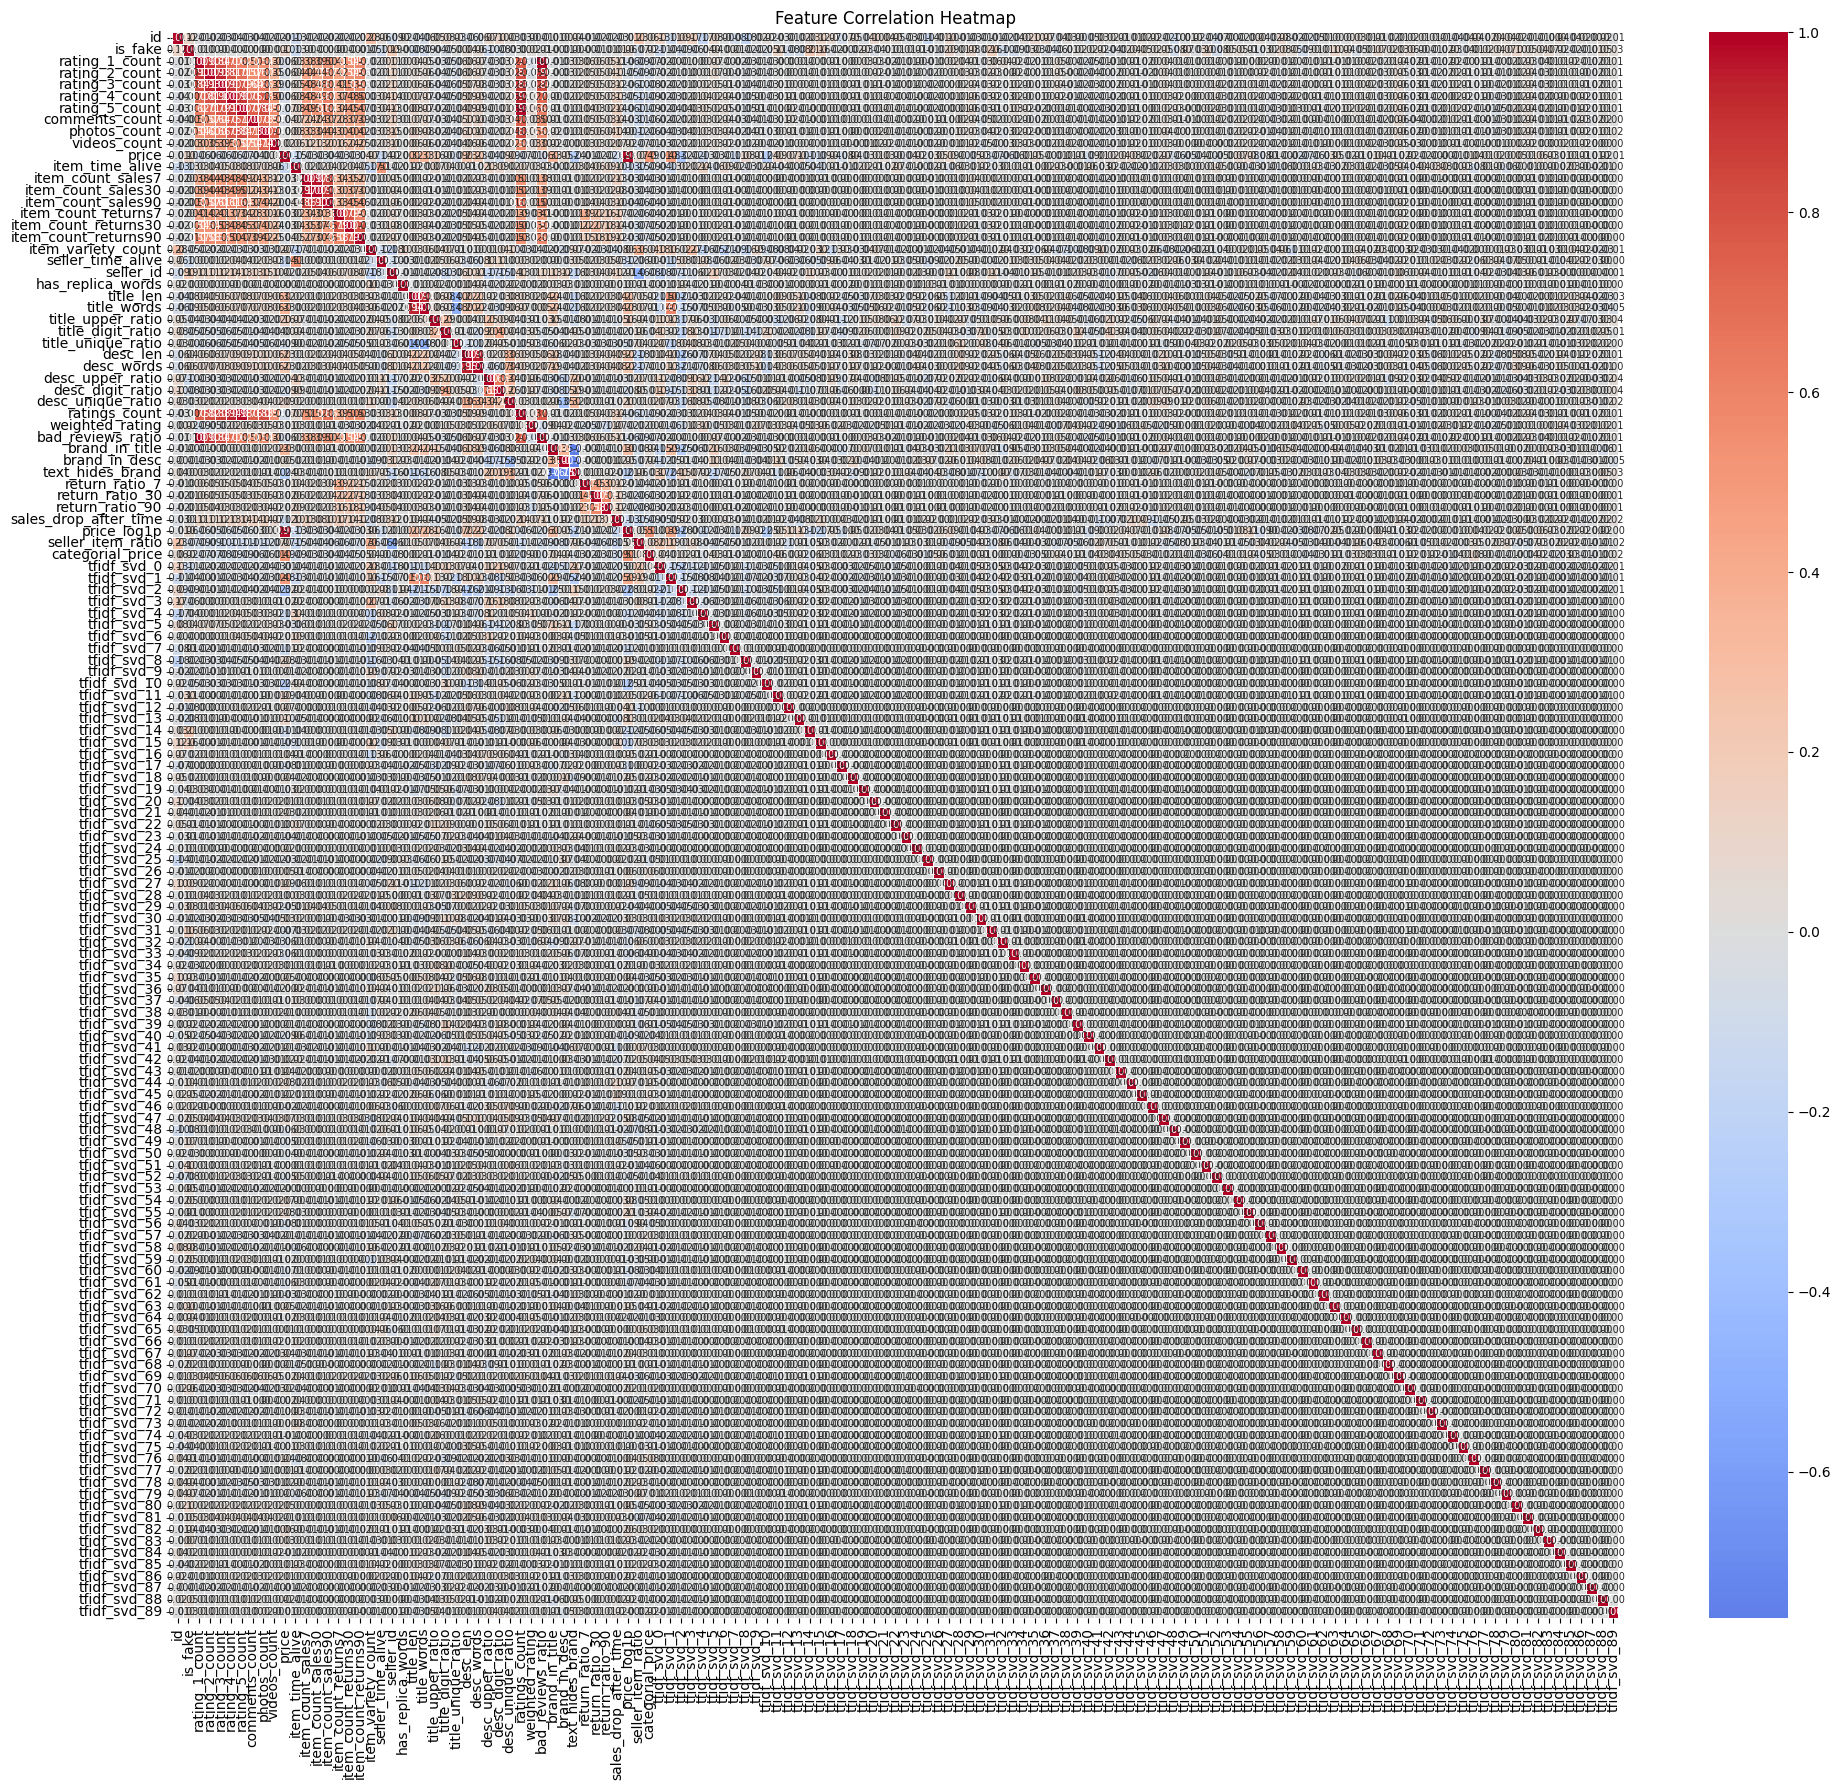

In [ ]:
cols_to_drop = [
    'brand',
    'category'
]

print("Dropping columns (if exist):", [c for c in cols_to_drop if c in train_prepared.columns])
train_prepared = train_prepared.drop(columns=cols_to_drop, errors='ignore')
if test_prepared is not None:
    test_prepared = test_prepared.drop(columns=cols_to_drop, errors='ignore')
train_prepared.info()

corr_matrix = train_prepared.corr()
corr_matrix["is_fake"].sort_values(ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt

corr = train_prepared.corr(numeric_only=True)

plt.figure(figsize=(20, 18))
ax = sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,
    fmt=".2f",
    xticklabels=True,
    yticklabels=True,
    annot_kws={"size": 7}
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
train_prepared.hist(figsize=(20, 10),bins=100);


